In [2]:
# Install Python Reddit API Wrapper
!pip install praw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 17.2 MB/s 
     |████████████████████████████████| 55 kB 2.0 MB/s 


In [ ]:
# Install trandformers package for sentiment analysis

!pip install -q transformers

In [71]:
import praw
import pprint
import re
from transformers import pipeline

In [4]:
# Credentials for API
# input your client id ans secret here following directions in documentation

reddit = praw.Reddit(client_id='cient_id',
                     client_secret='client_secret',
                     user_agent='cs410_useragent')

In [87]:
# Dictionary of courses talked about on reddit and their respective posts
course_post_dict = {}
# Choose pretrained sentiment analysis model
sentiment_pipeline = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [126]:
# Use API to get all posts 

def getPostsForCourse(course):
  if course.lower() in course_post_dict:
    return

  posts = []
  # remove leading and trailing white spaces
  course = course.strip()

  # can change time_filter to year/month to get more recent results
  for i in UIUC.search(query=course, time_filter="all", limit=5):
    posts.append(i)

  course_post_dict[course.lower()] = posts

In [106]:
#for each post, collect the top level comments (replies to comments not included)

def getCommentsForPosts(posts):
  comments = [] 

  for post in posts:
    for comment in post.comments:
      if ('[deleted]' not in comment.body):
        comments.append(comment.body)
  
  return comments

In [175]:
# clean the comments - remove unique characters, links, usernames, truncate comment if too long

def cleanText(x):
    # model already lowercases words
    # remove unicode characters
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'http*\S+', ' ', x)
    # then use regex to remove @ symbols and hashtags
    #x = re.sub(r'@\S', '', x)
    #x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    #x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    x = x[:200]
    return x

In [168]:
# Get the sentiment and score for each comment

def getSentiment(comments):
  cleaned = []
  for c in comments:
    cleaned.append(cleanText(c))
  
  res = sentiment_pipeline(cleaned)
  
  # sort comments in descending order by highest sentiment score
  labels = [sub['label'] for sub in res]
  scores = [sub['score'] for sub in res]
  zipped = zip(comments, labels, scores)
  sorted_zipped = sorted(zipped, key=lambda x: x[2], reverse=True)

  return sorted_zipped

In [119]:
# display top 5 comments with highest sentiment score

def OneCourseView(zippedlist):

  unzipped = list(zip(*zippedlist))
  i = 0
  print("TOP 5 POSTS WITH HIGHEST SENTIMENT SCORES \n\n")
  while (i < min(5, len(unzipped[0]))):
    if (unzipped[1][i] == 'NEG'):
      print('\033[91m' + unzipped[1][i] + ' ' + str(round(unzipped[2][i], 2)) + '\n' + unzipped[0][i])
    elif (unzipped[1][i] == 'POS'):
      print('\033[92m' + unzipped[1][i] + ' ' + str(round(unzipped[2][i], 2)) + '\n' + unzipped[0][i])
    else:
      print('\033[94m'+ unzipped[1][i] + ' ' + str(round(unzipped[2][i], 2)) + '\n' + unzipped[0][i])
    print('\n')
    i = i+1

In [186]:
# display graph showing number of Positive, Negative and Neutral comments for the two subjects to be compared

def TwoCourseView(a, b, name_a, name_b):

  X = ['POS','NEU','NEG']

  unzipped_a = list(zip(*a))
  unzipped_b = list(zip(*b))

  Y_s1 = [unzipped_a[1].count('POS'), unzipped_a[1].count('NEU'), unzipped_a[1].count('NEG')]
  Y_s2 = [unzipped_b[1].count('POS'), unzipped_b[1].count('NEU'), unzipped_b[1].count('NEG')]
    
  X_axis = np.arange(len(X))
    
  plt.bar(X_axis - 0.2, Y_s1, 0.4, label = name_a)
  plt.bar(X_axis + 0.2, Y_s2, 0.4, label = name_b)
    
  plt.xticks(X_axis, X)
  plt.xlabel("Sentiment")
  plt.ylabel("Number of Comments")
  plt.title("Number of Positive, Negative and Neutral comments for each course")
  plt.legend()
  plt.show()



1. Learn about a course 
2. Compare two courses
2
Enter first course: kin 104
Enter second course: ling 100


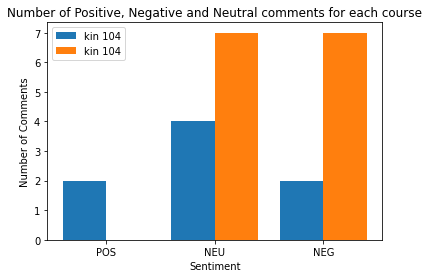

In [185]:
# MAIN CELL
# RUN ALL CELLS BEFORE and then run this cell to interact
import warnings
warnings.filterwarnings('ignore')

option = input ("1. Learn about a course \n2. Compare two courses\n")
if (option == '1'):
  c = input("Should I Take: ")
  c = c.lower()
  getPostsForCourse(c)
  com = getCommentsForPosts(course_post_dict[c])
  sen = getSentiment(com)
  OneCourseView(sen)

elif (option == '2'):
  a = input("Enter first course: ")
  a = a.lower()
  b = input("Enter second course: ")
  b = b.lower()
  getPostsForCourse(a)
  res_a = getSentiment(getCommentsForPosts(course_post_dict[a]))
  getPostsForCourse(b)
  res_b = getSentiment(getCommentsForPosts(course_post_dict[b]))
  TwoCourseView(res_a, res_b, a, b)

else:
  print("Invalid Option. Please run this cell and try again.")

